In [1]:
import configparser
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras.backend as K

from scipy.io import loadmat
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import optimizers
from utils import get_images_fullpath, load_groundtruth_illuminant
from imaging import srgb_gamma, correct_color_single_image
from error_metrics import compute_angular_error, compute_angular_error_stats

Using TensorFlow backend.


## Parse the config

In [2]:
shigehler_config = configparser.ConfigParser()
shigehler_config.read("./assets/shigehler.cfg")
img_folder_path = shigehler_config["SHIGEHLER"]["DB_PATH"]
gt_file_path = shigehler_config["SHIGEHLER"]["REAL_RGB"]
original_bitdepth = int(shigehler_config["SHIGEHLER"]["ORIGINAL_BITDEPTH"])
npatches_per_image = int(shigehler_config["SHIGEHLER"]["NPATCHES_PER_IMAGE"])

## Load dataset
- If you haven't generated dataset yet, please first run `shigehler_data_preparation.py`.

In [10]:
dataset = np.load('./assets/shigehler.npz')
patches = dataset['data']
patch_labels = dataset['patch_labels']
image_idx = dataset['image_idx']

In [11]:
print("patches shape: {}".format(patches.shape))
print("patch_labels shape: {}".format(patch_labels.shape))
print("image_idx shape: {}".format(image_idx.shape))

patches shape: (56800, 32, 32, 3)
patch_labels shape: (56800, 3)
image_idx shape: (56800,)


## CNN Model

In [12]:
euclidean_distance_loss = lambda y_true, y_pred: K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [13]:
def shigehler_model(): 
    """
    The network consists of 5 layers: 32×32×3 - 32×32×240 - 4×4×240 - 40 - 3
    """
    num_featmaps = 240  # This many filters per conv layer
    w, h = 1, 1         # conv window size
    model = Sequential()
    model.add(Conv2D(num_featmaps, (w, h), padding='same', 
                     kernel_initializer='glorot_uniform', input_shape=patches.shape[1:]))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Flatten())
    model.add(Dense(40, kernel_initializer='glorot_uniform', activation='relu')) 
    model.add(Dense(3))
    opt = optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.0005)
    model.compile(loss=euclidean_distance_loss, 
                  optimizer=opt, metrics=['mse'])
    return model

In [14]:
model = shigehler_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 240)       960       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 240)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                153640    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 123       
Total params: 154,723
Trainable params: 154,723
Non-trainable params: 0
_________________________________________________________________


In [15]:
te_split = loadmat('./assets/gehler_threefoldCVsplit.mat')['te_split'][0]

npatches = patches.shape[0]
nimages = npatches//npatches_per_image

TOTAL_RUN = 1

cnn_patch_stats = []
cnn_avg_pool_stats = []
cnn_median_pool_stats = []

cnn_patch_ang = np.zeros((npatches, TOTAL_RUN))
cnn_avg_pool_ang = np.zeros((nimages, TOTAL_RUN))
cnn_median_pool_ang = np.zeros((nimages, TOTAL_RUN))

# due to randomness in neural networks, average over TOTAL_RUN runs
for idx_run in range(TOTAL_RUN):
    
    cnn_est_patch_label = np.zeros((npatches, 3))
    cnn_est_avg_pool_label = np.zeros((nimages, 3))
    cnn_est_median_pool_label = np.zeros((nimages, 3))

    for idx_fold in range(3): # 3-fold CV
        
        print("run {} fold {}".format(idx_run+1, idx_fold+1))
        te_idx = te_split[idx_fold][0] - 1 # since Matlab indexes start at 1, we subtract 1
        idx_test = np.in1d(image_idx, te_idx)
        idx_train = ~idx_test
        X_train, y_train = patches[idx_train,...], patch_labels[idx_train,:]
        X_test, y_test = patches[idx_test,...], patch_labels[idx_test,:]

        model = shigehler_model()
        model.fit(X_train, y_train, epochs=8, batch_size=64)
        y_pred = model.predict(X_test)

        # generate a single illuminant estimation per image by pooling
        # the predicted patch illuminants
        for idx, idx_te in enumerate(te_idx):
            this_y_test = y_test[idx*npatches_per_image:(idx+1)*npatches_per_image]
            this_y_pred = y_pred[idx*npatches_per_image:(idx+1)*npatches_per_image]   
            cnn_est_patch_label[idx_te*npatches_per_image:(idx_te+1)*npatches_per_image, :] = this_y_pred
            cnn_est_avg_pool_label[idx_te, :] = np.mean(this_y_pred, axis=0)
            cnn_est_median_pool_label[idx_te, :] = np.median(this_y_pred, axis=0)
    
            cnn_patch_ang[idx_te*npatches_per_image:(idx_te+1)*npatches_per_image, idx_run] = compute_angular_error(this_y_test, this_y_pred)
        
        cnn_avg_pool_ang[te_idx, idx_run] = compute_angular_error(y_test[::npatches_per_image,:], cnn_est_avg_pool_label[te_idx, :])
        cnn_median_pool_ang[te_idx, idx_run] = compute_angular_error(y_test[::npatches_per_image,:], cnn_est_median_pool_label[te_idx, :])

    
    cnn_patch_stats.append(compute_angular_error_stats(cnn_patch_ang[:, idx_run]))
    cnn_avg_pool_stats.append(compute_angular_error_stats(cnn_avg_pool_ang[:, idx_run]))
    cnn_median_pool_stats.append(compute_angular_error_stats(cnn_median_pool_ang[:, idx_run]))

run 1 fold 1
Instructions for updating:
Use tf.cast instead.
Epoch 1/8
37900/37900 [==============================] - 79s 2ms/step - loss: 0.1210 - mse: 0.0113
Epoch 2/8
37900/37900 [==============================] - 78s 2ms/step - loss: 0.0915 - mse: 0.0051
Epoch 3/8
37900/37900 [==============================] - 78s 2ms/step - loss: 0.0892 - mse: 0.0050
Epoch 4/8
37900/37900 [==============================] - 80s 2ms/step - loss: 0.0874 - mse: 0.0049
Epoch 5/8
37900/37900 [==============================] - 75s 2ms/step - loss: 0.0865 - mse: 0.0049
Epoch 6/8
37900/37900 [==============================] - 78s 2ms/step - loss: 0.0857 - mse: 0.0048
Epoch 7/8
37900/37900 [==============================] - 80s 2ms/step - loss: 0.0855 - mse: 0.0048
Epoch 8/8
37900/37900 [==============================] - 78s 2ms/step - loss: 0.0852 - mse: 0.0048


/Users/hidiryuzuguzel/PycharmProjects/cc_cnn/error_metrics.py:20: RuntimeWarning: invalid value encountered in arccos
  err = np.degrees(np.arccos(dot))


run 1 fold 2
Epoch 1/8
37700/37700 [==============================] - 78s 2ms/step - loss: 0.1179 - mse: 0.0119
Epoch 2/8
37700/37700 [==============================] - 79s 2ms/step - loss: 0.0862 - mse: 0.0043
Epoch 3/8
37700/37700 [==============================] - 87s 2ms/step - loss: 0.0837 - mse: 0.0042
Epoch 4/8
37700/37700 [==============================] - 85s 2ms/step - loss: 0.0823 - mse: 0.0041
Epoch 5/8
37700/37700 [==============================] - 83s 2ms/step - loss: 0.0813 - mse: 0.0040
Epoch 6/8
37700/37700 [==============================] - 82s 2ms/step - loss: 0.0807 - mse: 0.0040
Epoch 7/8
37700/37700 [==============================] - 82s 2ms/step - loss: 0.0803 - mse: 0.0039
Epoch 8/8
37700/37700 [==============================] - 83s 2ms/step - loss: 0.0797 - mse: 0.0039
run 1 fold 3
Epoch 1/8
38000/38000 [==============================] - 85s 2ms/step - loss: 0.1194 - mse: 0.0107
Epoch 2/8
38000/38000 [==============================] - 85s 2ms/step - loss: 0.089

In [18]:
print("Patch-wise angular error statistics")
pd.DataFrame(cnn_patch_stats).mean()

Patch-wise angular error statistics


min        0.003082
10prc      0.798601
median     2.278043
mean       3.212543
90prc      6.666482
max       40.425522
dtype: float64

In [19]:
print("Average pooling angular error statistics")
pd.DataFrame(cnn_avg_pool_stats).mean()

Average pooling angular error statistics


min        0.064277
10prc      0.733307
median     2.181013
mean       2.748992
90prc      5.500645
max       15.510092
dtype: float64

In [20]:
print("Median pooling angular error statistics")
pd.DataFrame(cnn_median_pool_stats).mean()

Median pooling angular error statistics


min        0.097622
10prc      0.723876
median     2.080147
mean       2.719636
90prc      5.202001
max       18.606550
dtype: float64

## Testing CNN performance (visually)

In [3]:
db_images = get_images_fullpath(img_folder_path)
db_images[:5]

['/Users/hidiryuzuguzel/datasets/ShiGehlerRawDataset/png_canon1d/cs/chroma/data/canon_dataset/568_dataset/png/8D5U5524.png',
 '/Users/hidiryuzuguzel/datasets/ShiGehlerRawDataset/png_canon1d/cs/chroma/data/canon_dataset/568_dataset/png/8D5U5525.png',
 '/Users/hidiryuzuguzel/datasets/ShiGehlerRawDataset/png_canon1d/cs/chroma/data/canon_dataset/568_dataset/png/8D5U5526.png',
 '/Users/hidiryuzuguzel/datasets/ShiGehlerRawDataset/png_canon1d/cs/chroma/data/canon_dataset/568_dataset/png/8D5U5527.png',
 '/Users/hidiryuzuguzel/datasets/ShiGehlerRawDataset/png_canon1d/cs/chroma/data/canon_dataset/568_dataset/png/8D5U5528.png']

In [7]:
real_rgb = load_groundtruth_illuminant(gt_file_path)

In [4]:
im_idx = np.random.choice(len(db_images), 8)
im_idx

array([ 63, 527, 328, 176, 248, 277, 221, 368])

In [24]:
input_imgs = []
gt_imgs = []
cnn_imgs = []

for idx in im_idx:
    img = cv2.imread(db_images[idx], cv2.IMREAD_UNCHANGED).astype(np.float64)
    img = img[:,:,::-1] # convert BGR to RGB
    img = cv2.resize(img, (512, 512))
    # subtract black level: For the Canon 5D the black level is 129 and
    # for the Canon 1D it is zero.
    if "canon5d" in db_images[idx]:
        img = np.maximum(img - 129, 0)
    gt_img = correct_color_single_image(img, real_rgb[idx, :])
    cnn_img = correct_color_single_image(img, cnn_est_avg_pool_label[idx, :])
    
    img = img / (2**original_bitdepth -1)
    img = srgb_gamma(img)
    input_imgs.append(img)
    
    gt_img = gt_img / (2**original_bitdepth -1)
    gt_img = srgb_gamma(gt_img)
    gt_imgs.append(gt_img)
    
    cnn_img = cnn_img / (2**original_bitdepth -1)
    cnn_img = srgb_gamma(cnn_img)
    cnn_imgs.append(cnn_img)
    
input_imgs = np.concatenate(input_imgs, axis=1)
gt_imgs = np.concatenate(gt_imgs, axis=1)
cnn_imgs = np.concatenate(cnn_imgs, axis=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'CNN corrected images')

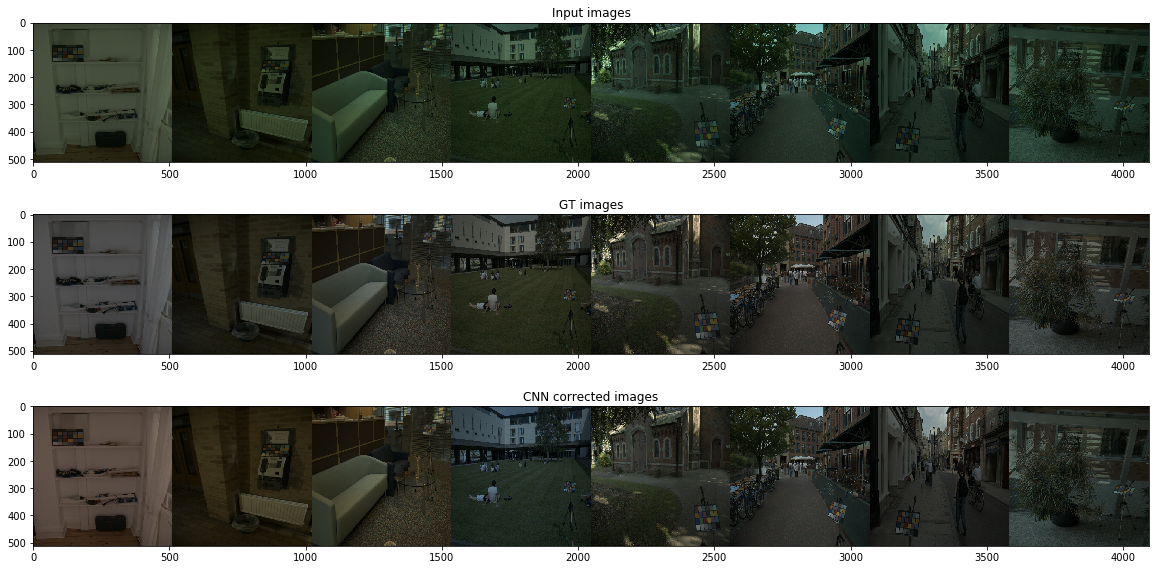

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
ax[0].imshow(input_imgs)
ax[0].set_title('Input images')
ax[1].imshow(gt_imgs)
ax[1].set_title('GT images')
ax[2].imshow(cnn_imgs)
ax[2].set_title('CNN corrected images')